# Quantity extraction and feature generation
from the Darknet database 'Evolution'


In [1]:
def initQuantityExtraction():
    from quantulum import parser  # Quantulum - Extract quantities from unstructured text
    import os
    from shutil import copyfile

    # add custom unit descriptor file to Quantulum package
    source_file = os.getcwd() + '/units.json'
    if not os.path.exists(source_file):
        print "Warning! Custom units.json does not exist."
    else:
        dest_file =  os.path.dirname(parser.__file__) + '/units.json'
        if not os.path.exists(dest_file):
            print "Warning! Custom units.json could not be copied"
        else:
            copyfile(source_file, dest_file)
            print "Custom units.json file copied to Quantulum folder"         

# extract quanities from listing titles
def extractQuantities(listingTitle):
    from quantulum import parser  # Quantulum - Extract quantities from unstructured text
  
    l = unicode(listingTitle)
    # Some vendors don't leave spaces, so let's fix that
    l = l.replace('half grams', '0.5 grams ', 1) # 1 space after
    l = l.replace('Grams', 'Grams ', 1) # 1 space after
    l = l.replace('g$', 'g,$', 1)       # separate g and $

    try:
        parsed_quantities = parser.parse(l)
    except:
        try:
            l=l.replace("/"," / ") # fix some exceptions that otherwise would break the parser
            l=l.replace("-","_")
            # and try again
            parsed_quantities = parser.parse(l)
        except:
            try:
                l = l.lower()
                l=l.replace(" to "," __ ") # fix some other exceptions that otherwise would break the parser
                l=l.replace("x 10"," ")
                parsed_quantities = parser.parse(l)
            except:
                print "Warning! Parser failed when parsing '"+l+"'"
    return parsed_quantities

# Extract quanities from listing title
# Function expects quantulum object and listing
def extractItemCount(quants, listingTitle):
    if len(quants)>0:
        # item count at the beginning?
        if quants[0].unit.name == 'dimensionless':
            s = listingTitle[quants[0].span[0]:quants[0].span[1]+2] # get the 2 characters after the quantity
            if 'x ' in s.lower():
                return quants[0].value
        # item count at the end of the listing?
        if quants[-1].unit.name == 'dimensionless':
            s = listingTitle[quants[-1].span[0]-3:quants[-1].span[1]] # get the 2 characters after the quantity
            if ' x' in s.lower():
                return quants[-1].value
    return 1 # if there's no count string, then the count is 1

# Extract quanities from listing title
def extractMassInGrams(quants):
    import numpy as np
    from pint import UnitRegistry # Pint - Physical quantities module
    ureg = UnitRegistry()
    
    mass_in_grams = np.nan
    for q in quants:
        quantity = abs(q.value)
        unit = q.unit.name
        entity = q.unit.entity.name
        # check if entity is a mass
        if entity == "mass":
            quantity_in_any_unit = quantity * ureg.parse_expression(q.unit.name)
            mass_in_grams_temp = quantity_in_any_unit.to('gram').magnitude
            # only overwrite if it's the first mass
            if np.isnan(mass_in_grams):
                mass_in_grams = mass_in_grams_temp
            # in case there are multiple masses keep the larger mass, with is likely the total mass
            if mass_in_grams_temp > mass_in_grams:
                mass_in_grams = mass_in_grams_temp
    return mass_in_grams

def getMasses(listings):
    # create an empty dataframe for the masses with the same index
    columns = {'mass_in_grams','count','total_mass_in_grams'}
    masses = pd.DataFrame(index=listings.index, columns=columns)
    # extract masses and write into new dataframe
    for ii, l in enumerate(listings['product']):
        print l
        quants = extractQuantities(l)         
        mass_in_grams = abs(extractMassInGrams(quants)) # extract quantity e.g. 10 gram
        count = extractItemCount(quants, l) # extract item count e.g. number if pills
        masses['mass_in_grams'][ii] = mass_in_grams
        masses['count'][ii] = count
        masses['total_mass_in_grams'][ii] = mass_in_grams*count
    return masses

def convert_BTC_to_USD(listings):
    # create a subset of listing only containing the BTC price
    listing_subset = listings.loc[:,('date','price')]
    # load the bitcoin exchange rate for every day
    BTC_USD_rate = pd.read_csv('./data/bitcoin_dollar_rate.csv') # BTC course for every single day
    BTC_USD_rate.columns = ['date', 'BTC_to_USD_exchange_rate']
    # match to dates of the BTC exchange rate to the listings
    listing_subset = pd.merge(listing_subset, BTC_USD_rate, how='left', on='date')
    # make new columns with BTC price and USD price
    price_in_BTC = listing_subset.price.str.replace("BTC","").str.strip().astype(float)
    listing_subset['price_in_BTC'] = price_in_BTC
    price_in_USD = price_in_BTC*listing_subset.BTC_to_USD_exchange_rate
    listing_subset['price_in_USD'] = price_in_USD
    return listing_subset

def get_price_per_gram(listings):
    import numpy as np
    # create a subset of listing only containing the price in USD and total mass
    listing_subset = listings.loc[:,('price_in_USD','total_mass_in_grams')]
    price_per_gram = listing_subset.price_in_USD/listing_subset.total_mass_in_grams
    # remove unreasonable prices, coming from typos in the BTC price column
    price_per_gram[price_per_gram>1e6] = np.nan
    # make new column with price per gram
    listing_subset['price_per_gram_in_USD'] = price_per_gram.values
    return listing_subset

def getTimeSeries(listings,mass_slice_low,mass_slice_high,first_date,number_of_days):
    import pandas as pd
    from datetime import datetime

    # create empty dataframe with index = 1-day frequency
    ts_dates = pd.date_range(first_date, periods=number_of_days, freq='D')
    ts = pd.DataFrame(index=ts_dates)
    # create date index for masses and prices
    dates = pd.to_datetime(listings.date, format='%Y-%m-%d')
    l = listings.loc[:,('price_in_USD','total_mass_in_grams')]
    l = pd.concat([dates, l], axis=1)
    # get the average price per day for a weight range
    mass_slices = [(1e-12,mass_slice_low,'small'),
                   (mass_slice_low,mass_slice_high,'medium'),
                   (mass_slice_high,1e12,'large')]
    for (low, high,size_text) in mass_slices:
        avg_price = l[(l.total_mass_in_grams>low) & 
                      (l.total_mass_in_grams<=high)].groupby('date')['price_in_USD'].mean()
        num_listings = l[(l.total_mass_in_grams>low) & 
                      (l.total_mass_in_grams<=high)].groupby('date')['price_in_USD'].count()
        avg_values = pd.DataFrame({'avg_price'+'/'+size_text: avg_price.values,
                                   'num_listings'+'/'+size_text: num_listings.values},
                                  index=avg_price.index)
        ts=ts.join(avg_values,how='left')
    # interpolate values
    try:
        ts=ts.interpolate(method='nearest')
    except ValueError:
        print "Error in getTimeSeries, skipping time series interpolation."
    return ts

def addNameToColumns(ts,product_name):
    col_names = []
    for col_name in ts.columns:
        col_names.append(product_name+'/'+col_name)
    ts.columns=col_names
    return ts

def plotMassHistogram(masses):
    import matplotlib.pyplot as plt
    n, bins, patches = plt.hist(masses, bins=(1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2,1e3,1e4,1e5),
                                normed=0, facecolor='blue', alpha=0.5, label="Product mass")

    fig = plt.figure(1)
    fig.suptitle('Fentanyl darknet market distribution', fontsize=15)
    plt.xlabel("Product mass (g)",fontsize=15)
    plt.ylabel("Number of listings",fontsize=15)
    plt.grid(True)
    plt.legend(shadow=True, fancybox=True)
    plt.xscale('log')
    plt.show()
    
def plotTimeSeries(ts):
    import matplotlib.pyplot as plt
    fig = plt.figure(2)
    ts.plot()
    plt.xlabel("Time",fontsize=15)
    plt.ylabel("Number of listings / Average price",fontsize=15)
    plt.grid(True)
    plt.legend(shadow=True, fancybox=True, loc='best')
    plt.yscale('log')
    plt.show()

# Generate feature
Load listings from SQL, extract quantites, generate timeseries, save into feature array X

Custom units.json file copied to Quantulum folder

Analyzing Fentanyl listings
Fentanyl Spray (30ml 200mcg/ml)
1 x 75mcg Fentanyl Patch 1734mg from 1A Pharma Sample Price
Fentanyl 100mcg/h Pachtch 2312mg HexalHighest DOSE Patch
Fentanyl 100mcg/hr (5 patches)
1 x 100g/h Fentanyl Matrix Patch containing 2312mg from 1A PHARMA
1X 50 mg/hr Fentanyl Transdermal System
Fentanyl Spray (30ml 200mcg/ml)
1 x 75mcg Fentanyl Patch 1734mg from 1A Pharma Sample Price
Fentanyl 100mcg/h Pachtch 2312mg HexalHighest DOSE Patch
1 x 100g/h Fentanyl Matrix Patch containing 2312mg from 1A PHARMA
1X 50 mg/hr Fentanyl Transdermal System
1 x 75g/h Fentanyl Matrix Patch - 12.375mg total TEVA NL
1 x 100g/h Fentanyl Matrix Patch - 16.5mg total TEVA NL
Fentanyl Spray (30ml 200mcg/ml)
1 x 75mcg Fentanyl Patch 1734mg from 1A Pharma Sample Price
Fentanyl 100mcg/h Pachtch 2312mg HexalHighest DOSE Patch
1 x 75g/h Fentanyl Matrix Patch - 12.375mg total TEVA NL
1 x 100g/h Fentanyl Matrix Patch - 16.5mg total TEVA NL
Butyr

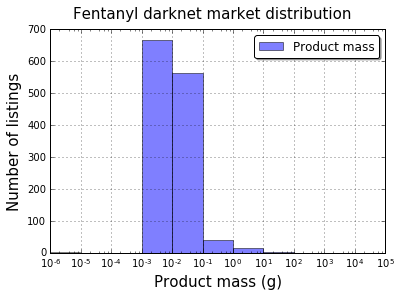

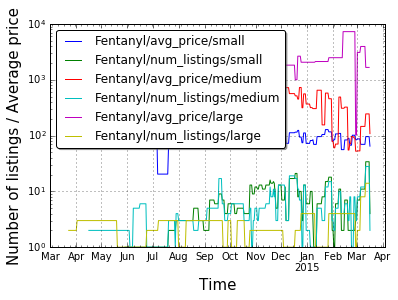


Analyzing Acetylfentanyl listings
100mg Acetyl Fentanyl
250mg Acetyl Fentanyl
500mg Acetyl Fentanyl
100mg Acetyl Fentanyl
250mg Acetyl Fentanyl
500mg Acetyl Fentanyl
100mg Acetyl Fentanyl
250mg Acetyl Fentanyl
500mg Acetyl Fentanyl
100mg Acetyl Fentanyl
100mg Acetyl Fentanyl
Acetyl-Fentanyl  1/4 gram
Acetyl-Fentanyl  1/4 gram
Acetyl-Fentanyl  1/4 gram
Acetyl Fentanyl Powder  100mg (.100)
Acetyl Fentanyl Powder  100mg (.100)
Acetyl Fentanyl Powder  100mg (.100)
250 mg Acetyl Fentanyl Shipped from USA
1 g Acetyl Fentanyl Shipped from USA
Acetyl Fentanyl Powder  100mg (.100)
250 mg Acetyl Fentanyl Shipped from USA
1 g Acetyl Fentanyl Shipped from USA
Acetyl Fentanyl Powder  100mg (.100)
250 mg Acetyl Fentanyl Shipped from USA
1 g Acetyl Fentanyl Shipped from USA
Acetyl Fentanyl Powder  100mg (.100)
250 mg Acetyl Fentanyl Shipped from USA
1 g Acetyl Fentanyl Shipped from USA
Acetyl Fentanyl Powder  100mg (.100)
250 mg Acetyl Fentanyl Shipped from USA
1 g Acetyl Fentanyl Shipped from USA
A

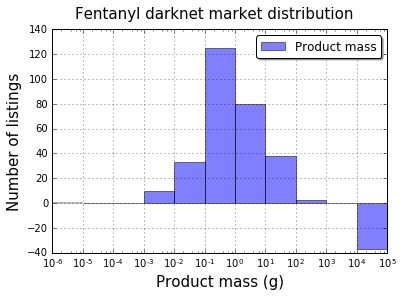

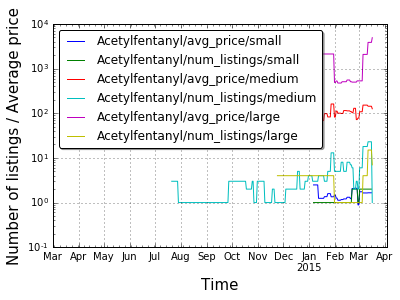


Analyzing Butyrfentanyl listings
Butyrfentanyl nasal spray 1x10ml
Butyrfentanyl nasal spray 1x10ml
Butyrfentanyl nasal spray 1x10ml
Butyrfentanyl nasal spray 1x10ml
Butyrfentanyl nasal spray 1x10ml
Butyrfentanyl nasal spray 1x10ml
Butyrfentanyl nasal spray 1x10ml
Butyrfentanyl nasal spray 1x10ml
Butyrfentanyl nasal spray 1x10ml
Butyrfentanyl nasal spray 1x10ml
Butyrfentanyl nasal spray 1x10ml
Butyrfentanyl nasal spray 1x10ml
Butyrfentanyl nasal spray 1x10ml
Butyrfentanyl nasal spray 1x10ml
Butyrfentanyl nasal spray 1x10ml
50mg Butyrfentanyl (99%)
(AUS) Butyr Fentanyl 25mg 99% Pure Chemical
(AUS) Butyr Fentanyl 10mg 99% Pure Chemical
50mg Butyrfentanyl (99%)
SALE (AUS) Butyr Fentanyl 10mg 99% Pure Chemical
SALE (AUS) Butyr Fentanyl 25mg 99% Pure Chemical
Special 20mg Butyrfentanyl (99%)
50mg Butyrfentanyl (99%)
Butyr Fentanyl 1g


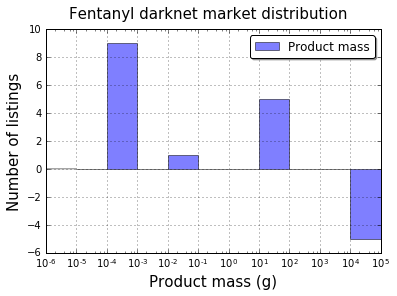

Error in getTimeSeries, skipping time series interpolation.


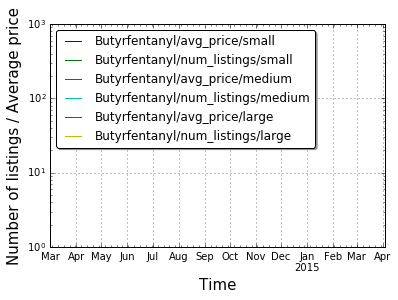


Analyzing Actiq listings
3 x Fentanyl Actiq Lolipops 200g each
3 x Fentanyl Actiq Lolipops 200g each
3 x Fentanyl Actiq Lolipops 200g each
3 x Fentanyl Actiq Lolipops 200g each
3 x Fentanyl Actiq Lolipops 200g each
3 x Fentanyl Actiq Lolipops 200g each
3 x Fentanyl Actiq Lolipops 200g each
3 x Fentanyl Actiq Lolipops 200g each
3 x Fentanyl Actiq Lolipops 200g each
3 x Fentanyl Actiq Lolipops 200g each
3 x Fentanyl Actiq Lolipops 200g each
3 x Fentanyl Actiq Lolipops 200g each
3 x Fentanyl Actiq Lolipops 200g each
3 x Fentanyl Actiq Lolipops 200g each
ACTIQ FENTANYL LOLLIPOPS 600mcg $25


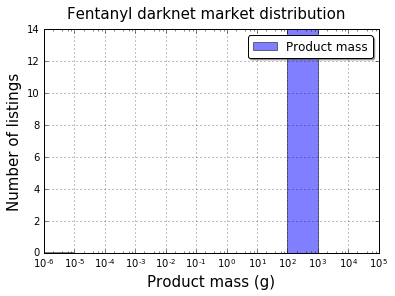

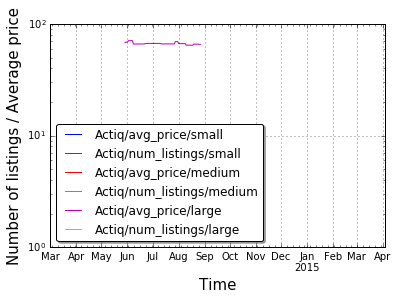


Analyzing Duragesic listings
1x Duragesic Fentanyl Patch (100mcg/hr) (SafetySpeedService)
1x Duragesic Fentanyl Patch (100mcg/hr) (SafetySpeedService)
Fentanyl 100mcg Patch from Duragesic Highest Dose Patch


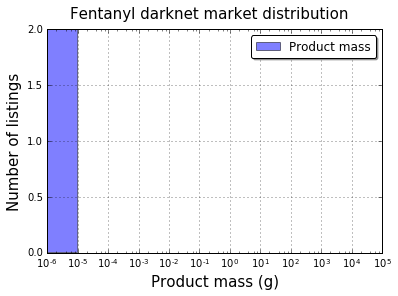

Error in getTimeSeries, skipping time series interpolation.


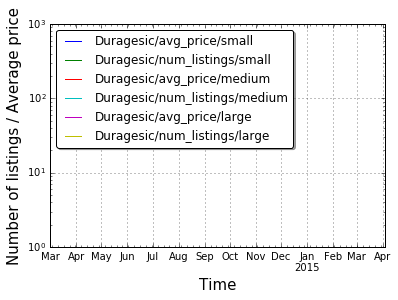


Analyzing Fentanyl Hcl listings
25mg Butyr-fentanyl hcl
25mg Butyr-fentanyl hcl
25mg Butyr-Fentanyl HCL (99%) - 25 X stronger than morphin
50mg Butyr-Fentanyl HCL (99%) - 25 X stronger than morphin
100mg Butyr-Fentanyl HCL (99%) - 25 X stronger than morphin
250mg Butyr-Fentanyl HCL (99%) - 25 X stronger than morphin
500mg Butyr-Fentanyl HCL (99%) - 25 X stronger than morphin
25mg Butyr-fentanyl hcl
25mg Butyr-Fentanyl HCL (99%) - 25 X stronger than morphin
50mg Butyr-Fentanyl HCL (99%) - 25 X stronger than morphin
100mg Butyr-Fentanyl HCL (99%) - 25 X stronger than morphin
250mg Butyr-Fentanyl HCL (99%) - 25 X stronger than morphin
500mg Butyr-Fentanyl HCL (99%) - 25 X stronger than morphin
25mg Butyr-fentanyl hcl
25mg Butyr-Fentanyl HCL (99%) - 25 X stronger than morphin
50mg Butyr-Fentanyl HCL (99%) - 25 X stronger than morphin
100mg Butyr-Fentanyl HCL (99%) - 25 X stronger than morphin
250mg Butyr-Fentanyl HCL (99%) - 25 X stronger than morphin
500mg Butyr-Fentanyl HCL (99%) - 25 X

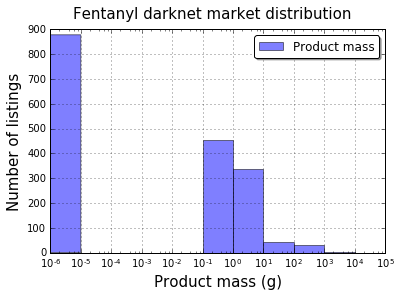

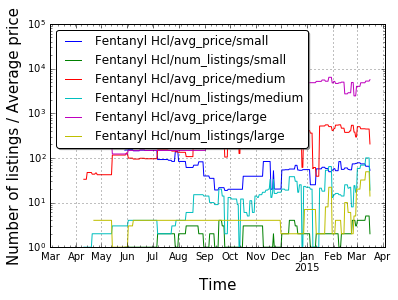


Analyzing China White listings
1.5 Gram China White Fentanyl Mannitol Mix
1.5 Gram China White Fentanyl Mannitol Mix
1 Ounce of China White Fentanyl Mannitol Mix
3.5 grams of China White Fentanyl Mannitol Mix
1/2 Ounce of China White Fentanyl Mannitol Mix
1.5 Gram China White Fentanyl Mannitol Mix
1 Ounce of China White Fentanyl Mannitol Mix
3.5 grams of China White Fentanyl Mannitol Mix
100mg of China White Fentanyl Mannitol Mix
1/2 Ounce of China White Fentanyl Mannitol Mix
1.5 Gram China White Fentanyl Mannitol Mix
1 Ounce of China White Fentanyl Mannitol Mix
3.5 grams of China White Fentanyl Mannitol Mix
1/2 Ounce of China White Fentanyl Mannitol Mix
1.5 Gram China White Fentanyl Mannitol Mix
1 Ounce of China White Fentanyl Mannitol Mix
3.5 grams of China White Fentanyl Mannitol Mix
100mg of China White Fentanyl Mannitol Mix
1/2 Ounce of China White Fentanyl Mannitol Mix
1.5 Gram China White Fentanyl Mannitol Mix
1.5 Gram China White Fentanyl Mannitol Mix
1 Ounce of China White Fe

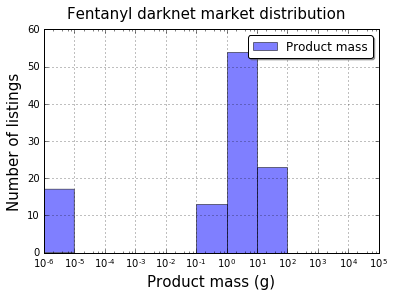

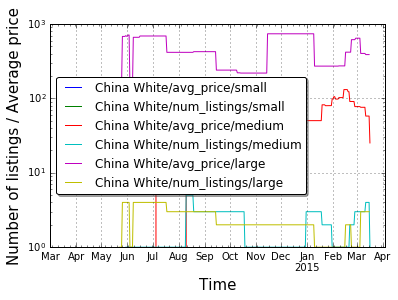

,Fentanyl/avg_price/small,Fentanyl/num_listings/small,Fentanyl/avg_price/medium,Fentanyl/num_listings/medium,Fentanyl/avg_price/large,Fentanyl/num_listings/large,Acetylfentanyl/avg_price/small,Acetylfentanyl/num_listings/small,Acetylfentanyl/avg_price/medium,Acetylfentanyl/num_listings/medium,...,Fentanyl Hcl/avg_price/medium,Fentanyl Hcl/num_listings/medium,Fentanyl Hcl/avg_price/large,Fentanyl Hcl/num_listings/large,China White/avg_price/small,China White/num_listings/small,China White/avg_price/medium,China White/num_listings/medium,China White/avg_price/large,China White/num_listings/large
2014-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-03-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-03-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-03-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-03-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-03-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-03-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-03-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-03-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-03-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import pandas as pd
import numpy as np
import pymysql as mdb
%matplotlib inline

# initialize the quantity extraction functions
initQuantityExtraction()

# parameter for time series generation
(mass_slice_low,mass_slice_high) = (0.01,1) # in g
first_date = '2014-03-01'
number_of_days = 400

# initialize the feature array X
ts_dates = pd.date_range(first_date, periods=number_of_days, freq='D')
X = pd.DataFrame(index=ts_dates)

# load the Fentanyl dictionary containing drug groups and synonyms
fentanyl_dict = pd.read_csv('./data/FentanylDictionary.csv')

# generate SQL query: drug_group + any of the synonyms
for ii, product_name in enumerate(fentanyl_dict.Product):
    drug_group = fentanyl_dict.Group[ii]
    synonyms = fentanyl_dict.Synonym[ii]
    query = "SELECT * " \
            "FROM listings " \
            "WHERE ( "
    for synonym in synonyms.split(','):
        if len(synonym) > 1:
            query += "product LIKE '%%%s%%' OR " % synonym
    query = query[:-3]
    query += ") AND "
    query += "( product LIKE '%%%s%%'" % drug_group
    query += ") " \
             ";"

    # special query: just Fentanyl and no synonyms
    if synonyms=='---none---':
        all_synonyms=[]
        for synonym_str in fentanyl_dict.Synonym:
            for synonym in synonym_str.split(','):
                if len(synonym)> 1:
                    all_synonyms.append(synonym)
        query = "SELECT * " \
                "FROM listings " \
                "WHERE NOT ( "
        for synonym in all_synonyms:
            query += "product LIKE '%%%s%%' OR " % synonym
        query = query[:-3]
        query += ") AND "
        query += "( product LIKE '%%%s%%'" % drug_group
        query += ") " \
                 ";"
 
    # get listings from database
    con = None
    con = mdb.connect('localhost', 'userX', 'qwerty', 'evolution_db') #host, user, password, #database
    listings = pd.read_sql_query(query,con)

    if not listings.empty:
        # save product name for this search
        print
        print 'Analyzing '+product_name+' listings'

        # convert Bitcoin prices into USD, add to listings df
        prices = convert_BTC_to_USD(listings)
        prices = prices.drop(['date','price'], axis=1)
        listings = pd.concat([listings, prices], axis=1)

        # extract masses, add to listings df
        masses = getMasses(listings)
        listings = pd.concat([listings, masses], axis=1)

        # get price per gram
        price_per_gram = get_price_per_gram(listings)
        price_per_gram = price_per_gram.drop(['price_in_USD','total_mass_in_grams'], axis=1)
        listings = pd.concat([listings, price_per_gram], axis=1)
        
        # check if listings contained information about the mass of the product
        if not listings.total_mass_in_grams.isnull().all():
            # plot histogram
            plotMassHistogram(listings.total_mass_in_grams)

            # calculate time series, separate total mass into 3 ranges
            ts=getTimeSeries(listings,
                             mass_slice_low,
                             mass_slice_high,
                             first_date,
                             number_of_days)
            
            # add product_name to the time series column name
            ts = addNameToColumns(ts,product_name)

            plotTimeSeries(ts)
            
            # save everything into large dataframe X for medelling
            X = pd.concat([X, ts], axis=1)
            
# display features X
X.head(10)

# Save as features X

In [11]:
# drop empty columns
X = X.dropna(how='all',axis=1)
print 'Number of columns in X array = '+str(X.shape[1])
# save feature array X
X.to_pickle('./data/Fentanyl_Feature_X.pkl')
print 'Feature array X saved!'

Number of columns in X array = 30
Feature array X saved!
